# Approche “Modèle sur mesure avancé”

On va tester plusieurs modèles et choisir le meilleur pour ensuite l'entraîner et le déployer sur Azure Machine Learning

In [10]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import pandas as pd
import numpy as np
import time

from sklearn import metrics
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, Dense, Dropout, LSTM, Flatten, Bidirectional, TextVectorization, Activation
from keras.models import Sequential, load_model
from keras.callbacks import TensorBoard, EarlyStopping
from keras.metrics import AUC
import tensorflow as tf

import spacy
from nltk.stem import PorterStemmer

from gensim.models import word2vec

import src.helpers.data_helpers as dth

### Chargement des données

In [11]:
# Charger les données depuis le fichier csv
data = pd.read_csv('data/training.1600000.processed.noemoticon.csv', sep=',', encoding = "ISO-8859-1", header=None, names=['target', 'id', 'date', 'flag', 'user', 'text'])

# Ne garder que les colonnes nécessaires
data = data[["text", "target"]]

# On supprime les tweets en doublons
data.drop_duplicates(subset=['text'], inplace=True)

# Remplacer les valeurs par les vrais labels
data['target'] = data['target'].map(
    {
        0: "NEGATIF",
        4: "POSITIF"
    }
)

# Binarize target
data['target'] = data['target'].map(
    {
        "NEGATIF": 0,
        "POSITIF": 1,
    }
)

data.describe()

,target
count,1.581466e+06
mean,5.003465e-01
std,5.000000e-01
min,0.000000e+00
25%,0.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


Comme on travaille en local pour déterminer le meilleur modèle, on va travailler sur un échantillion de 50 000 tweets afin de diminuer les temps de calcul.

Le meilleur modèle sera ré-entraîné sur Azure Machine Learning en utilisant la totalité du jeu de données.

In [23]:
# Echantillon du jeu de données
sample_positif = data[data["target"] == 1].sample(n = 2000)
sample_negatif = data[data["target"] == 0].sample(n = 2000)

sample = pd.concat([sample_negatif, sample_positif])

X = sample['text']
y = sample['target']

### Choix des métriques

Pour déterminer le meilleur modèle on fera une synthèse comparative avec les métriques suivantes :

- f1 score
- accuracy
- Recall
- ROC AUC
- Temps pour l'entraînement

In [40]:
import json

synthese = {}
train_times = {}
if os.path.exists('models/train_times.json'):
    with open('models/train_times.json', 'r') as f:
        train_times = json.load(f)

### Modèle simple avec lemmatisation / stemming et embedding Word2Vec / Glove

On va commencer par un modèle de Deep Learning simple composé d'une couche d'Embedding, une couche LSTM et une couche Dense.

On entraîne le modèle 4 fois en changeant la technique de prétraitement du texte, et la méthode de plongement de mots.

**Prétraitement du texte :**

- Lemmatisation
- Stemming

**Plongement de mots :**

- Word2Vec
- Glove



In [14]:
nlp = spacy.load('en_core_web_sm')

all_stopwords = nlp.Defaults.stop_words

# Ajout / Suppression de stop words
all_stopwords.add('re')
if 'not' in all_stopwords:
    all_stopwords.remove('not')

In [25]:
# Prétraitement du texte aveec lemmatization et suppression des stops words, des caractères spéciaux et passage en minuscule
X_lemma = [[token.lemma_.lower() for token in doc if token.is_alpha and token.lemma_.lower() not in all_stopwords] for doc in nlp.pipe(X)]

In [26]:
ps = PorterStemmer()

# Prétraitement du texte aveec stemming et suppression des stops words, des caractères spéciaux et passage en minuscule
X_stemm = [[ps.stem(token.text) for token in doc if token.is_alpha and token.text.lower() not in all_stopwords] for doc in nlp.pipe(X)]

In [27]:
X_train_lemma, X_test_lemma, y_train_lemma, y_test_lemma = train_test_split(X_lemma, y, test_size=0.2, stratify=y, random_state=42)

In [28]:
X_train_stemm, X_test_stemm, y_train_stemm, y_test_stemm = train_test_split(X_stemm, y, test_size=0.2, stratify=y, random_state=42)

In [4]:
# Dictionnaire pour le plongement de mots avec Glove
emmbed_dict = {}
with open('data/glove.twitter.27B.200d.txt', 'r', encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        emmbed_dict[word] = vector

print(f'Il y a {len(emmbed_dict)} mots vectorisés')

Il y a 1193514 mots vectorisés


In [19]:
# Retourne l'embedding avec Word2Vec
def createEmbeddingLayerWord2Vec(tokenizer, X_train):
    w2v_model = word2vec.Word2Vec(vector_size=300, min_count=5)

    w2v_model.build_vocab(X_train)

    w2v_model.train(X_train, total_examples=w2v_model.corpus_count, epochs=32)

    vocab_size = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_size, 300))

    for word, i in tokenizer.word_index.items():
        if word in w2v_model.wv.index_to_key:
            embedding_matrix[i] = w2v_model.wv.get_vector(word, norm=True)

    return Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

# Retourne l'embedding avec Glove
def createEmbeddingLayerGlove(tokenizer, emmbed_dict):

    vocab_size = len(tokenizer.word_index) + 1

    embedding_matrix = np.zeros((vocab_size, 200))

    for word, i in tokenizer.word_index.items():
        embedding_vector = emmbed_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return Embedding(vocab_size, 200, weights=[embedding_matrix], input_length=200, trainable=False)

In [29]:
# Tokenizer avec lemmatization
tokenizer_lemma = Tokenizer()
tokenizer_lemma.fit_on_texts(X_train_lemma)

# Tokenizer avec stemming
tokenizer_stemm = Tokenizer()
tokenizer_stemm.fit_on_texts(X_train_stemm)

def tokenize_data(data,tokenizer,maxlen=None):
    X = tokenizer.texts_to_sequences(data)
    return pad_sequences(X,maxlen=maxlen)

In [32]:
# Modèle de deep learning simple
def trainModel(model_name, embedding_layer, X_train, y_train, X_test, y_test, embedding_dim, tokenizer):

    x_train = tokenize_data(X_train,tokenizer,maxlen=embedding_dim)
    x_test = tokenize_data(X_test,tokenizer,maxlen=embedding_dim)

    model_path = os.path.join('models', model_name)

    if os.path.exists(model_path):
        model = load_model(model_path)
        training_time = train_times[model_name]

    else:
        start_train = time.time()
        # Create LSTM Model
        model = Sequential(name=model_name)
        model.add(embedding_layer)
        model.add(LSTM(256))

        # Classification layer
        model.add(Dense(1, activation='sigmoid'))

        # Compile
        model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

        print(model.summary())

        # Train
        model.fit(
            x_train,
            y_train,
            validation_split=0.2,
            epochs = 4,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,)

        # Save the model
        model.save(model_path)

        end_train = time.time()
        training_time = end_train - start_train
        train_times[model_name] = training_time

    start_pred = time.time()

    y_test_pred_proba = model.predict(
        x_test,
        batch_size=128,
        workers=4,
        use_multiprocessing=True,
    )

    y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

    end_pred= time.time()
    predict_time = end_pred - start_pred

    synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

    print(f"Resultats modèle : {model_name}")

    dth.plot_classifier_results(model, x_test, y_test, y_test_pred, y_test_pred_proba)

Entraînement des 4 modèles

Model: "stemm_word2vec_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 300)          1535400   
                                                                 
 lstm_2 (LSTM)               (None, 256)               570368    
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,106,025
Trainable params: 570,625
Non-trainable params: 1,535,400
_________________________________________________________________
None
Epoch 1/4
80/80 [==============================] - 69s 841ms/step - loss: 0.6931 - auc: 0.5282 - accuracy: 0.5246 - val_loss: 0.6885 - val_auc: 0.5750 - val_accuracy: 0.5406
Epoch 2/4
80/80 [==============================] - 68s 849ms/step - loss: 0.6895 - auc: 0.5526 - accuracy: 0.5434 - 

INFO:tensorflow:Assets written to: models\stemm_word2vec_lstm\assets


INFO:tensorflow:Assets written to: models\stemm_word2vec_lstm\assets


Resultats modèle : stemm_word2vec_lstm


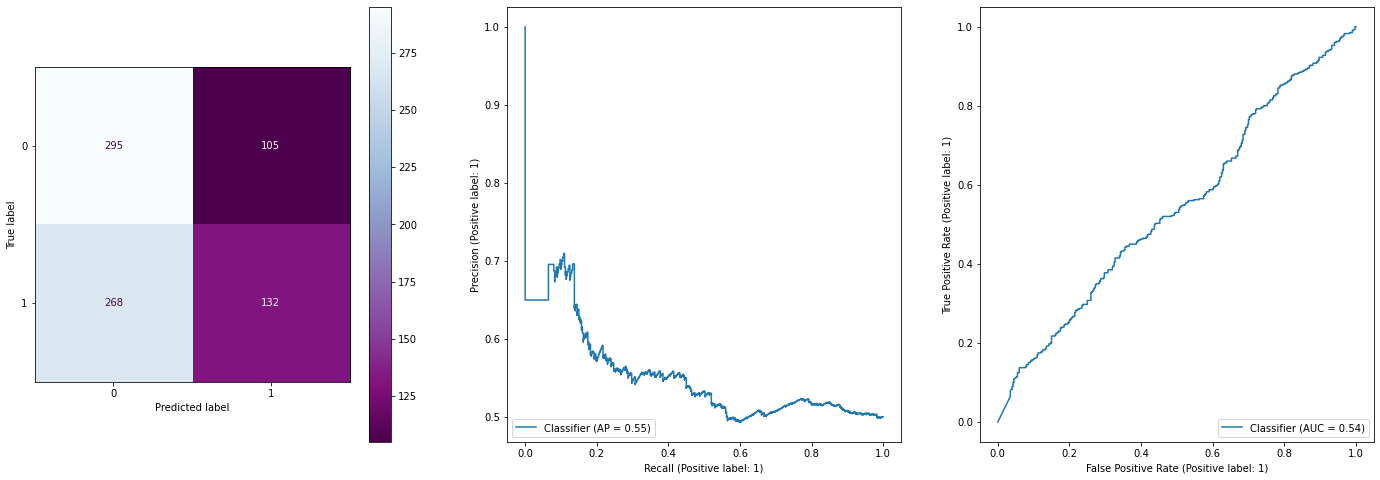

Model: "lemma_word2vec_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          1614900   
                                                                 
 lstm_3 (LSTM)               (None, 256)               570368    
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 2,185,525
Trainable params: 570,625
Non-trainable params: 1,614,900
_________________________________________________________________
None
Epoch 1/4
80/80 [==============================] - 78s 935ms/step - loss: 0.6961 - auc: 0.5206 - accuracy: 0.5137 - val_loss: 0.6916 - val_auc: 0.5693 - val_accuracy: 0.5094
Epoch 2/4
80/80 [==============================] - 71s 882ms/step - loss: 0.6902 - auc: 0.5490 - accuracy: 0.5340 - 

INFO:tensorflow:Assets written to: models\lemma_word2vec_lstm\assets


INFO:tensorflow:Assets written to: models\lemma_word2vec_lstm\assets


Resultats modèle : lemma_word2vec_lstm


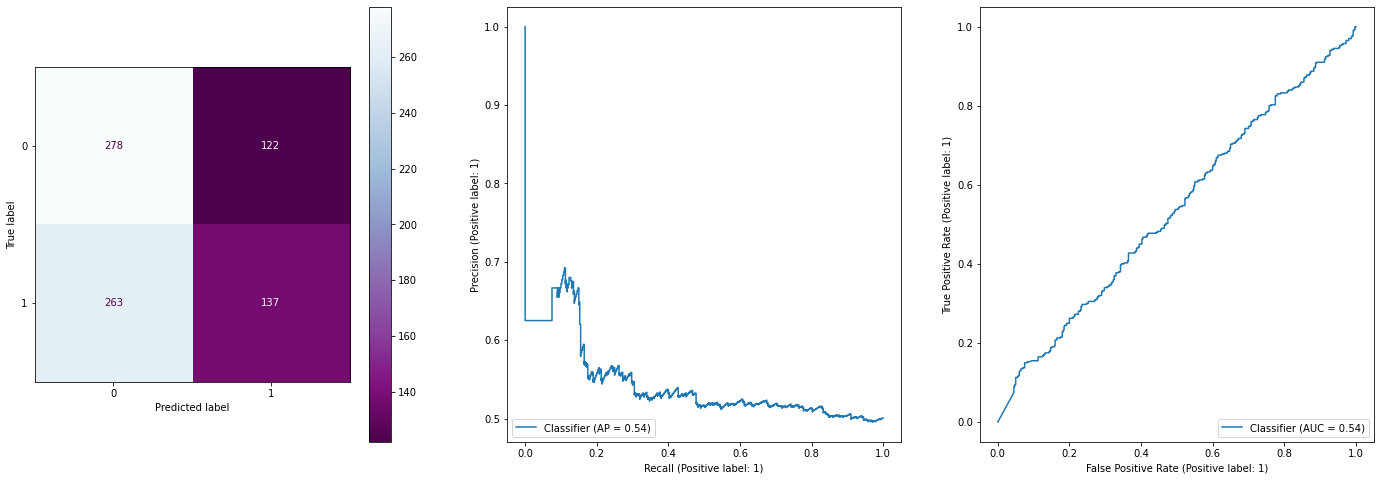

Model: "stemm_glove_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 200)          1023600   
                                                                 
 lstm_4 (LSTM)               (None, 256)               467968    
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,491,825
Trainable params: 468,225
Non-trainable params: 1,023,600
_________________________________________________________________
None
Epoch 1/4
80/80 [==============================] - 36s 426ms/step - loss: 0.6079 - auc: 0.7305 - accuracy: 0.6676 - val_loss: 0.5618 - val_auc: 0.7886 - val_accuracy: 0.7078
Epoch 2/4
80/80 [==============================] - 36s 447ms/step - loss: 0.5254 - auc: 0.8157 - accuracy: 0.7398 - val

INFO:tensorflow:Assets written to: models\stemm_glove_lstm\assets


INFO:tensorflow:Assets written to: models\stemm_glove_lstm\assets


Resultats modèle : stemm_glove_lstm


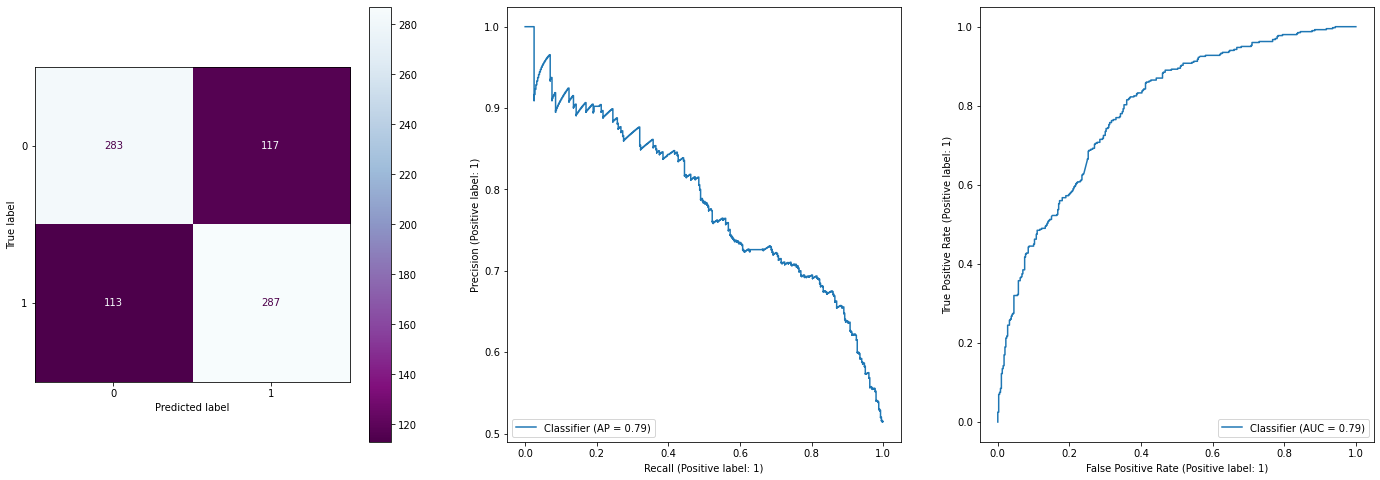

Model: "lemma_glove_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 200)          1076600   
                                                                 
 lstm_5 (LSTM)               (None, 256)               467968    
                                                                 
 dense_5 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,544,825
Trainable params: 468,225
Non-trainable params: 1,076,600
_________________________________________________________________
None
Epoch 1/4
80/80 [==============================] - 35s 417ms/step - loss: 0.5964 - auc: 0.7438 - accuracy: 0.6707 - val_loss: 0.5498 - val_auc: 0.7972 - val_accuracy: 0.7312
Epoch 2/4
80/80 [==============================] - 33s 408ms/step - loss: 0.5064 - auc: 0.8287 - accuracy: 0.7465 - val

INFO:tensorflow:Assets written to: models\lemma_glove_lstm\assets


INFO:tensorflow:Assets written to: models\lemma_glove_lstm\assets


Resultats modèle : lemma_glove_lstm


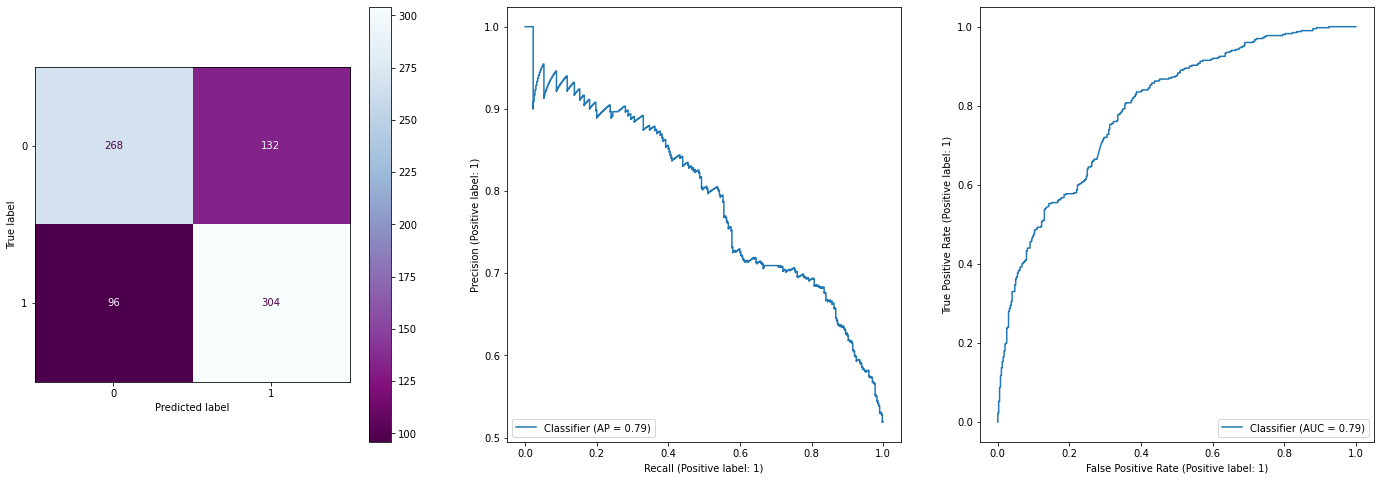

In [33]:
trainModel('stemm_word2vec_lstm', createEmbeddingLayerWord2Vec(tokenizer_stemm, X_train_stemm), X_train_stemm, y_train_stemm, X_test_stemm, y_test_stemm, 300, tokenizer_stemm)

trainModel('lemma_word2vec_lstm', createEmbeddingLayerWord2Vec(tokenizer_lemma, X_train_lemma), X_train_lemma, y_train_lemma, X_test_lemma, y_test_lemma, 300, tokenizer_lemma)

trainModel('stemm_glove_lstm', createEmbeddingLayerGlove(tokenizer_stemm, emmbed_dict), X_train_stemm, y_train_stemm, X_test_stemm, y_test_stemm, 200, tokenizer_stemm)

trainModel('lemma_glove_lstm', createEmbeddingLayerGlove(tokenizer_lemma, emmbed_dict), X_train_lemma, y_train_lemma, X_test_lemma, y_test_lemma, 200, tokenizer_lemma)

In [34]:
synthese

{'stemm_word2vec_lstm': {'f1 score': 0.41444270015698587,
  'accuracy': 0.53375,
  'recall': 0.33,
  'AUC': 0.5421374999999999,
  'Training time': 273.7289204597473,
  'Predict time': 4.495614290237427},
 'lemma_word2vec_lstm': {'f1 score': 0.41578148710166923,
  'accuracy': 0.51875,
  'recall': 0.3425,
  'AUC': 0.535971875,
  'Training time': 292.1805784702301,
  'Predict time': 5.276055812835693},
 'stemm_glove_lstm': {'f1 score': 0.7139303482587064,
  'accuracy': 0.7125,
  'recall': 0.7175,
  'AUC': 0.79344375,
  'Training time': 139.3899440765381,
  'Predict time': 3.248685836791992},
 'lemma_glove_lstm': {'f1 score': 0.7272727272727273,
  'accuracy': 0.715,
  'recall': 0.76,
  'AUC': 0.7935531250000001,
  'Training time': 134.74329829216003,
  'Predict time': 3.4438536167144775}}

### Modèle Feed-Forward Neural Network

Avec un simple vecteur comptant les mots en entrée, sans prétraitement de texte

In [5]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

In [6]:
model_name = "ffnn_on_count"
vocabulary_size = 10000

model_path = os.path.join('models', model_name)

if os.path.exists(model_path):
    model = load_model(model_path)
    training_time = train_times[model_name]

else:
    start_train = time.time()
    # Define vectorizer
    vectorize_layer = TextVectorization(
            output_mode="count",
            max_tokens=vocabulary_size,
            pad_to_max_tokens=True,
        )
    vectorize_layer.adapt(
            X,
            batch_size=128,
        )

    # define NN model
    model = Sequential(name=model_name)
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(vectorize_layer)
    model.add(Dense(100, input_shape=(vocabulary_size,), activation="relu"))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))

    # compile NN network
    model.compile(
            loss="binary_crossentropy",
            optimizer="adam",
            metrics=[
                "accuracy",
                AUC(curve="ROC", name="ROC_AUC"),
                AUC(curve="PR", name="AP"),
            ],
        )

    # fit NN model
    model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=128,
            validation_split=0.2,
            callbacks=[
                EarlyStopping(monitor="val_loss", patience=2),
            ],
            workers=4,
            use_multiprocessing=True,
        )

    # Save the model
    model.save(model_path)
    
    end_train = time.time()
    training_time = end_train - start_train
    train_times[model_name] = training_time

Epoch 1/10
200/200 [==============================] - 4s 13ms/step - loss: 0.5651 - accuracy: 0.7211 - ROC_AUC: 0.7886 - AP: 0.7763 - val_loss: 0.4970 - val_accuracy: 0.7709 - val_ROC_AUC: 0.8451 - val_AP: 0.8424
Epoch 2/10
200/200 [==============================] - 2s 12ms/step - loss: 0.4274 - accuracy: 0.8093 - ROC_AUC: 0.8860 - AP: 0.8840 - val_loss: 0.4798 - val_accuracy: 0.7742 - val_ROC_AUC: 0.8522 - val_AP: 0.8486
Epoch 3/10
200/200 [==============================] - 2s 12ms/step - loss: 0.3433 - accuracy: 0.8534 - ROC_AUC: 0.9286 - AP: 0.9299 - val_loss: 0.5050 - val_accuracy: 0.7727 - val_ROC_AUC: 0.8466 - val_AP: 0.8399
Epoch 4/10
200/200 [==============================] - 3s 13ms/step - loss: 0.2596 - accuracy: 0.8955 - ROC_AUC: 0.9602 - AP: 0.9614 - val_loss: 0.5550 - val_accuracy: 0.7634 - val_ROC_AUC: 0.8395 - val_AP: 0.8317


In [7]:
start_pred = time.time()

y_test_pred_proba = model.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

end_pred = time.time()
predict_time = end_pred - start_pred

synthese[model_name] = dth.getMetrics(y_test, y_test_pred, y_test_pred_proba, training_time, predict_time)

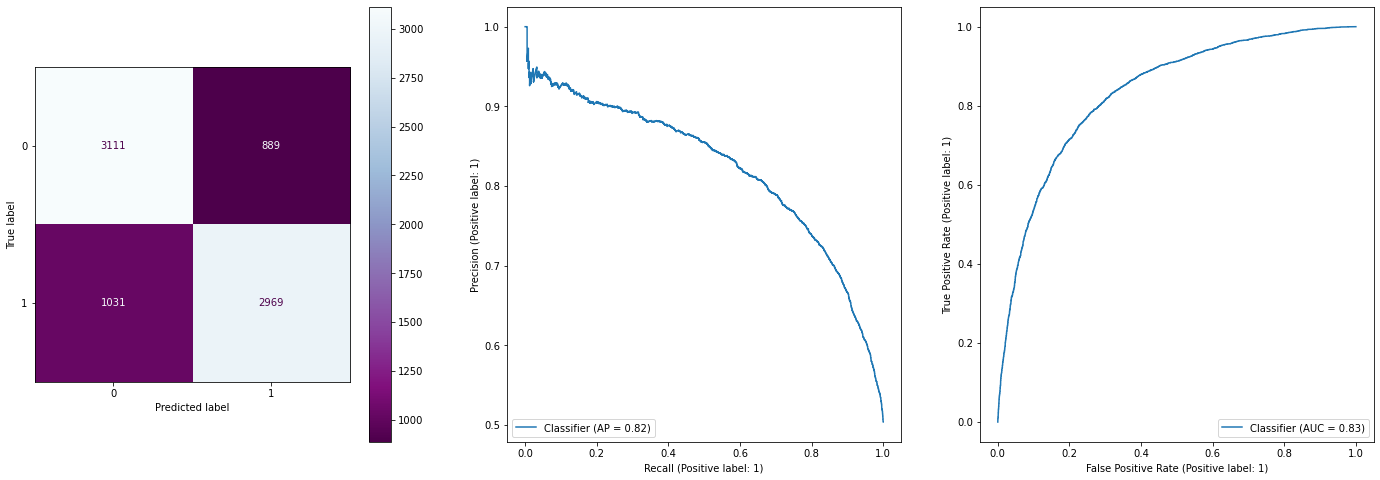

In [8]:
dth.plot_classifier_results(model, X_test, y_test, y_test_pred, y_test_pred_proba)

## Modèle bidirectional LSTM (embedding automatique)

Chaque mot est converti en nombre, et l'embedding est automatique sur la couche Embedding

In [9]:
model_name = "bidirectional_lstm"
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

# Define vectorizer
vectorize_layer = TextVectorization(
        output_mode="int",
        max_tokens=max_features,
        output_sequence_length=sequence_length,
    )
vectorize_layer.adapt(
        X,
        batch_size=128,
    )

# define NN model
model = Sequential(name=model_name)
model.add(Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)

# Embedding layer
model.add(
        Embedding(
            max_features,
            embedding_dim,
            input_length=sequence_length,
        )
    )

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

# Dense layers
model.add(Dense(100, input_shape=(max_features,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="relu"))

# Classification layer
model.add(Dense(1, activation="sigmoid"))

# compile NN network
model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=[
            "accuracy",
            AUC(curve="ROC", name="ROC_AUC"),
            AUC(curve="PR", name="AP"),
        ],
    )

# fit NN model
model.fit(
        X_train,
        y_train,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=4,
        use_multiprocessing=True,
    )

Epoch 1/10
200/200 [==============================] - 20s 83ms/step - loss: 0.5709 - accuracy: 0.6957 - ROC_AUC: 0.7712 - AP: 0.7678 - val_loss: 0.4768 - val_accuracy: 0.7777 - val_ROC_AUC: 0.8564 - val_AP: 0.8558
Epoch 2/10
200/200 [==============================] - 19s 96ms/step - loss: 0.4344 - accuracy: 0.8026 - ROC_AUC: 0.8807 - AP: 0.8801 - val_loss: 0.4724 - val_accuracy: 0.7803 - val_ROC_AUC: 0.8563 - val_AP: 0.8543
Epoch 3/10
200/200 [==============================] - 19s 94ms/step - loss: 0.3761 - accuracy: 0.8359 - ROC_AUC: 0.9121 - AP: 0.9135 - val_loss: 0.5049 - val_accuracy: 0.7694 - val_ROC_AUC: 0.8511 - val_AP: 0.8468
Epoch 4/10
200/200 [==============================] - 20s 98ms/step - loss: 0.3201 - accuracy: 0.8625 - ROC_AUC: 0.9371 - AP: 0.9395 - val_loss: 0.5431 - val_accuracy: 0.7638 - val_ROC_AUC: 0.8426 - val_AP: 0.8354


In [117]:
y_test_pred_proba = model.predict(
    X_test,
    batch_size=128,
    workers=4,
    use_multiprocessing=True,
)

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

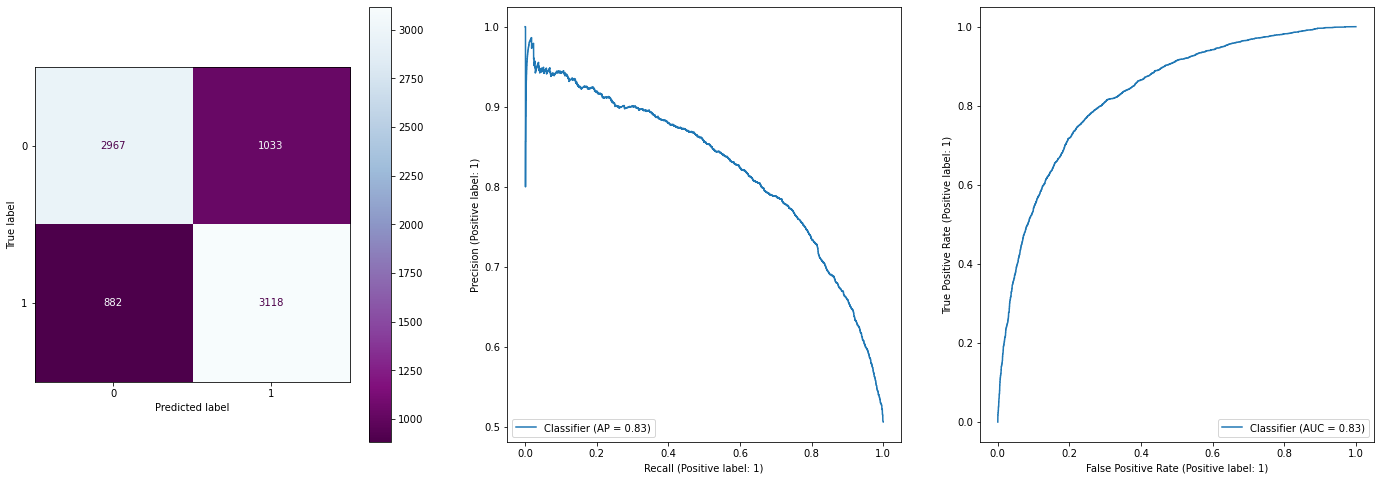

In [13]:
dth.plot_classifier_results(model, X_test, y_test, y_test_pred, y_test_pred_proba)

## Modèle bidirectionnal LSTM (Embedding personnalisé)

- C'est fois ci sur la couche d'Embedding on utilise le meilleur plongement de mots déterminé précédemment: **Glove**.
- Un prétaitement de texte est appliqué sur les tweets avec la **Lemmatisation**

Epoch 1/10
200/200 [==============================] - 233s 1s/step - loss: 0.5627 - auc: 0.7809 - accuracy: 0.7088 - val_loss: 0.5186 - val_auc: 0.8211 - val_accuracy: 0.7409
Epoch 2/10
200/200 [==============================] - 237s 1s/step - loss: 0.5157 - auc: 0.8235 - accuracy: 0.7436 - val_loss: 0.5068 - val_auc: 0.8302 - val_accuracy: 0.7461
Epoch 3/10
200/200 [==============================] - 245s 1s/step - loss: 0.4990 - auc: 0.8360 - accuracy: 0.7553 - val_loss: 0.5106 - val_auc: 0.8304 - val_accuracy: 0.7475
Epoch 4/10
200/200 [==============================] - 250s 1s/step - loss: 0.4874 - auc: 0.8444 - accuracy: 0.7617 - val_loss: 0.5013 - val_auc: 0.8332 - val_accuracy: 0.7486
Epoch 5/10
200/200 [==============================] - 236s 1s/step - loss: 0.4750 - auc: 0.8530 - accuracy: 0.7701 - val_loss: 0.5033 - val_auc: 0.8362 - val_accuracy: 0.7489
Epoch 6/10
200/200 [==============================] - 246s 1s/step - loss: 0.4606 - auc: 0.8626 - accuracy: 0.7773 - val_loss

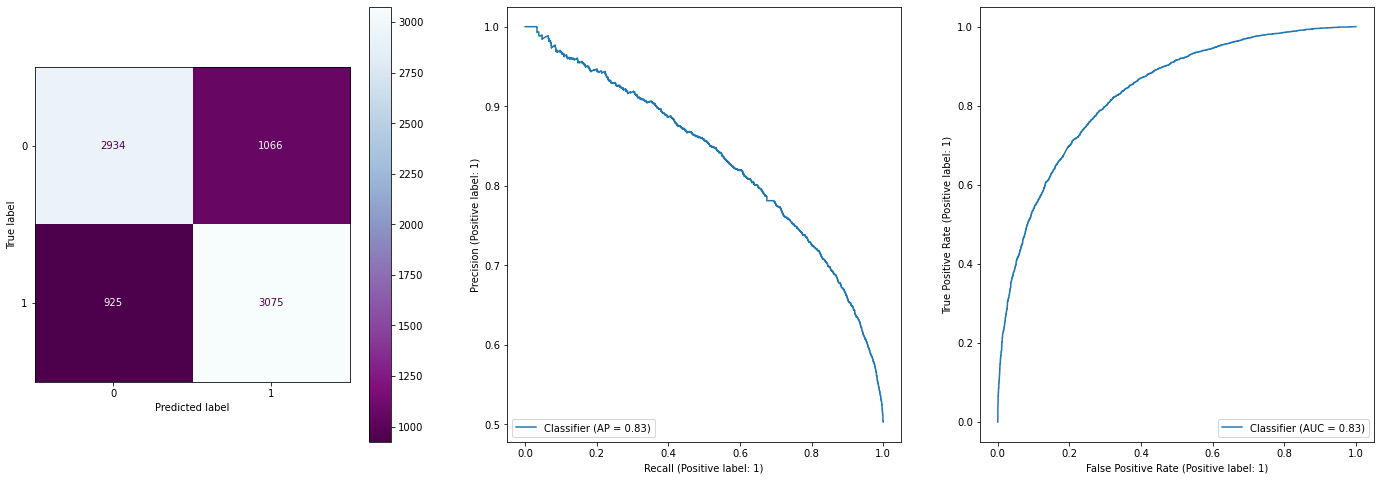

In [25]:
embedding_layer = createEmbeddingLayerGlove(tokenizer_lemma, emmbed_dict)

x_train_lemma = tokenize_data(X_train_lemma, tokenizer_lemma, maxlen=200)
x_test_lemma = tokenize_data(X_test_lemma, tokenizer_lemma, maxlen=200)

model_name = "bidirectional_lstm"
max_features = 10000
sequence_length = 30
embedding_dim = 100
rnn_units = 100

# define NN model
model = Sequential(name=model_name)
model.add(embedding_layer)

# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(units=rnn_units, dropout=0.2)))

# Dense layers
model.add(Dense(100, input_shape=(max_features,), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="relu"))

# Classification layer
model.add(Dense(1, activation="sigmoid"))

# compile NN network
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ["AUC","accuracy"])

# fit NN model
model.fit(
        x_train_lemma,
        y_train_lemma,
        epochs=10,
        batch_size=128,
        validation_split=0.2,
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=4,
        use_multiprocessing=True,
    )

y_test_pred_proba = model.predict(
        x_test_lemma,
        batch_size=128,
        workers=4,
        use_multiprocessing=True,
    )

y_test_pred = [round(pred_proba[0]) for pred_proba in y_test_pred_proba]

print(f"Resultats modèle : {model_name}")

dth.plot_classifier_results(model, x_test_lemma, y_test_lemma, y_test_pred, y_test_pred_proba)

## Modèle BERT

In [59]:
X_cleaned= pd.Series(" ".join([token.text.lower() for token in doc if token.is_alpha and token.text.lower() not in all_stopwords]) for doc in nlp.pipe(X))

In [62]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_cleaned,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42,
)

In [63]:
from transformers import BertTokenizer, TFBertModel, BertConfig, TFBertForSequenceClassification
import tensorflow as tf

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\romai/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\romai/.cache\huggingface\transformers\c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\romai/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005b

In [64]:
max_len = 0

for tweet in X_cleaned:
    max_len = max(max_len, len(tweet))

print('Max tweet length: ', max_len)

Max tweet length:  117


In [78]:
def mask_inputs_for_bert(tweets, max_len):
    input_ids = []
    attention_masks = []

    for tweet in tweets:
        encoded_dict = tokenizer.encode_plus(
            tweet,
            add_special_tokens = True,
            max_length = max_len,
            truncation=True,
            padding='max_length',
            return_attention_mask = True
        )
    
        input_ids.append(encoded_dict['input_ids'])

        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.convert_to_tensor(input_ids)
    attention_masks = tf.convert_to_tensor(attention_masks)
    
    return input_ids, attention_masks

In [79]:
train_inp, train_mask = mask_inputs_for_bert(X_train, max_len)
test_inp, test_mask = mask_inputs_for_bert(X_test, max_len)
train_label = tf.convert_to_tensor(y_train)
test_label = tf.convert_to_tensor(y_test)

In [82]:
print("Train_input shape", train_inp.shape)
print("Train_mask shape", train_mask.shape)
print("Test_input shape", test_inp.shape)
print("Test_mask shape", test_mask.shape)
print("Train_label shape", train_label.shape)
print("Test_label shape", test_label.shape)

Train_input shape (8000, 117)
Train_mask shape (8000, 117)
Test_input shape (2000, 117)
Test_mask shape (2000, 117)
Train_label shape (8000,)
Test_label shape (2000,)


In [52]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at C:\Users\romai/.cache\huggingface\transformers\3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

https://huggingface.co/bert-base-uncased/resolve/main/tf_model.h5 not found in cache or force_d

In [87]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5, epsilon=1e-08)

bert_model.compile(
        loss=loss,
        optimizer=optimizer,
        metrics=[metric])

In [88]:

bert_model.fit(
        [train_inp, train_mask],
        train_label,
        epochs=10,
        batch_size=128,
        validation_data=([test_inp, test_mask], test_label),
        callbacks=[
            EarlyStopping(monitor="val_loss", patience=2),
        ],
        workers=4,
        use_multiprocessing=True,
    )

Epoch 1/10
63/63 [==============================] - 7391s 117s/step - loss: 0.6079 - accuracy: 0.6647 - val_loss: 0.5213 - val_accuracy: 0.7530
Epoch 2/10
63/63 [==============================] - 7304s 116s/step - loss: 0.4906 - accuracy: 0.7731 - val_loss: 0.5068 - val_accuracy: 0.7605
Epoch 3/10
63/63 [==============================] - 7157s 114s/step - loss: 0.4128 - accuracy: 0.8189 - val_loss: 0.5141 - val_accuracy: 0.7605
Epoch 4/10
63/63 [==============================] - 7335s 117s/step - loss: 0.3248 - accuracy: 0.8684 - val_loss: 0.6142 - val_accuracy: 0.7460


In [96]:
y_test_pred_proba = bert_model([test_inp, test_mask])

In [101]:
prediction_logits = y_test_pred_proba[0]

In [102]:
prediction_probs = tf.nn.softmax(prediction_logits,axis=1).numpy()

In [134]:
prediction_probs_bis = []

for element in prediction_probs:
    prediction_probs_bis.append(element[1])

In [135]:
y_test_pred = [round(pred_proba) for pred_proba in prediction_probs_bis]

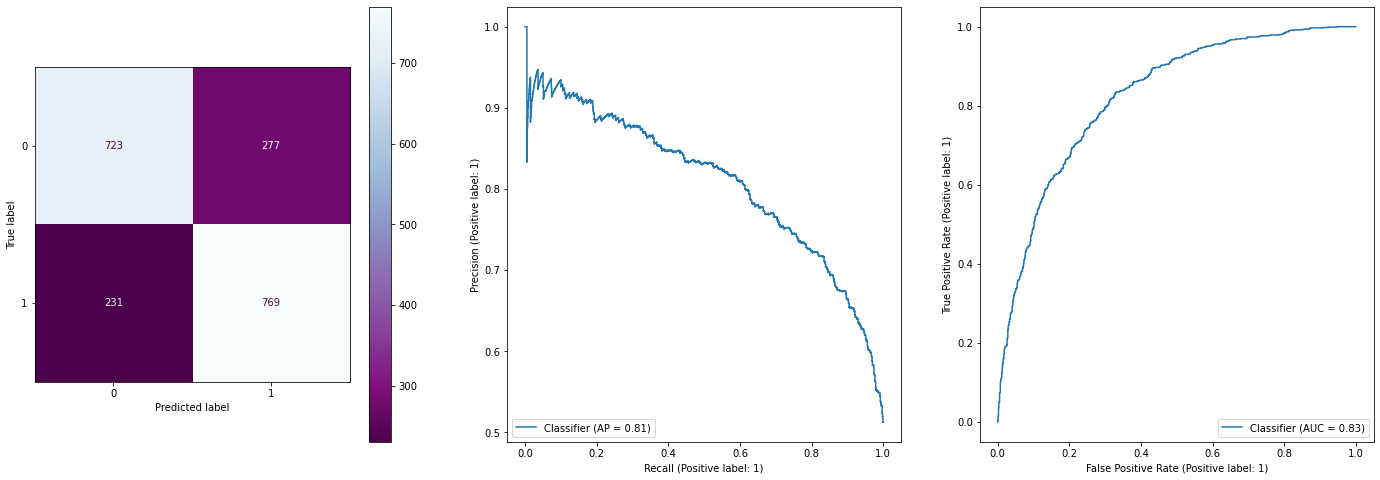

In [136]:
dth.plot_classifier_results(bert_model, [test_inp, test_mask], y_test, y_test_pred, prediction_probs_bis)

In [ ]:
with open('models/train_times.json', 'w') as f:
    json.dump(train_times, f)

In [ ]:
pd.DataFrame.from_dict(synthese, orient='index')